In [ ]:
#import libraries

In [1]:
import os
import re
import nltk
import requests
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import files
uploaded=files.upload()

Saving book (1).csv to book (1).csv


In [3]:
df = pd.read_csv('/content/book (1).csv',encoding='latin 1')
df.head()

,Unnamed: 0,User.ID,Book.Title,Book.Rating
0,1,276726,Classical Mythology,5
1,2,276729,Clara Callan,3
2,3,276729,Decision in Normandy,6
3,4,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,5,276737,The Mummies of Urumchi,6


In [4]:
#checking shape of the data
df.shape

(10000, 4)

In [5]:
#checking for any null values
df.isna().sum()

Unnamed: 0     0
User.ID        0
Book.Title     0
Book.Rating    0
dtype: int64

In [6]:
#dropping our column unnamed
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [7]:
#renaming our columns
df.rename({'User.ID':'User_Id','Book.Title':'Book_title','Book.Rating':'Ratings'},axis=1,inplace=True)

In [8]:
df.head()

,User_Id,Book_title,Ratings
0,276726,Classical Mythology,5
1,276729,Clara Callan,3
2,276729,Decision in Normandy,6
3,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,276737,The Mummies of Urumchi,6


In [9]:
#checking with duplicate columns
df[df.duplicated()]

,User_Id,Book_title,Ratings
5051,2152,Le nouveau soleil de Teur,7
7439,3757,The Magician's Tale,7


In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.shape

(9998, 3)

In [12]:
df[df.index.duplicated()]

,User_Id,Book_title,Ratings


In [13]:
#checking with unique number of user id
df.User_Id.value_counts().sort_values(ascending=False)

3757      522
162052    214
2276      212
4017      156
277427    150
         ... 
160894      1
160899      1
160909      1
160917      1
162129      1
Name: User_Id, Length: 2182, dtype: int64

In [14]:
#checking with number of unique number of book titles
df.Book_title.value_counts().sort_values(ascending=False)

Fahrenheit 451                                                5
The Amber Spyglass (His Dark Materials, Book 3)               4
Ender's Game (Ender Wiggins Saga (Paperback))                 4
The Subtle Knife (His Dark Materials, Book 2)                 4
Vanished                                                      4
                                                             ..
Book Finds: How to Find, Buy, and Sell Used and Rare Books    1
The Natural (Perennial Classics)                              1
The End Of Alice                                              1
A Gracious Plenty : A Novel                                   1
Kids Say the Darndest Things                                  1
Name: Book_title, Length: 9659, dtype: int64

In [15]:
#checking with total number of unique ratings
df.Ratings.value_counts().sort_values(ascending=False)

8     2283
7     2074
10    1732
9     1493
5     1007
6      920
4      237
3      146
2       63
1       43
Name: Ratings, dtype: int64

In [16]:
#checking with very unpopular items or low ratings
low_ratings = df[df['Ratings']<5]
low_ratings

,User_Id,Book_title,Ratings
1,276729,Clara Callan,3
19,276762,Beloved (Plume Contemporary Fiction),3
20,276762,Our Dumb Century: The Onion Presents 100 Years...,4
21,276768,New Vegetarian: Bold and Beautiful Recipes for...,4
115,276853,A Kiss Remembered,1
...,...,...,...
9942,162052,The Concrete Enema: And Other News of the Weir...,2
9943,162052,Empire Falls,4
9947,162052,Cloudsplitter,4
9948,162052,Leaving Home,1


In [17]:
#checking for titles with neutral ratings
neutral_ratings = df[df['Ratings']==5]
neutral_ratings

,User_Id,Book_title,Ratings
0,276726,Classical Mythology,5
15,276755,The Witchfinder (Amos Walker Mystery Series),5
17,276762,Goodbye to the Buttermilk Sky,5
35,276796,Tage der Unschuld.,5
36,276798,Lying Awake,5
...,...,...,...
9970,162063,Five Quarters of the Orange,5
9973,162085,To Asmara,5
9978,162092,Cherry,5
9979,162092,Tending to Virginia,5


In [18]:
#checking with very popular items or high ratings
high_ratings = df[df['Ratings']>5]
high_ratings

,User_Id,Book_title,Ratings
2,276729,Decision in Normandy,6
3,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,276737,The Mummies of Urumchi,6
5,276744,The Kitchen God's Wife,7
6,276745,What If?: The World's Foremost Military Histor...,10
...,...,...,...
9995,162121,American Fried: Adventures of a Happy Eater.,7
9996,162121,Cannibal In Manhattan,9
9997,162121,How to Flirt: A Practical Guide,7
9998,162121,Twilight,8


In [19]:
#checking top 10 books with highest ratings
top_10_books = high_ratings.Book_title.value_counts().head(10)
top_10_books

Fahrenheit 451                                     4
The Subtle Knife (His Dark Materials, Book 2)      4
Stardust                                           4
Pet Sematary                                       3
Suzanne's Diary for Nicholas                       3
The Amber Spyglass (His Dark Materials, Book 3)    3
The Golden Compass (His Dark Materials, Book 1)    3
Wuthering Heights                                  3
Vanished                                           3
Pride and Prejudice                                3
Name: Book_title, dtype: int64

In [20]:
mycolors = ["#023535","#015958","#008F8C","#0CABA8","#0FC2C0","#04BF8A","#025940","#03A64A","#F27457","#BF665E"]

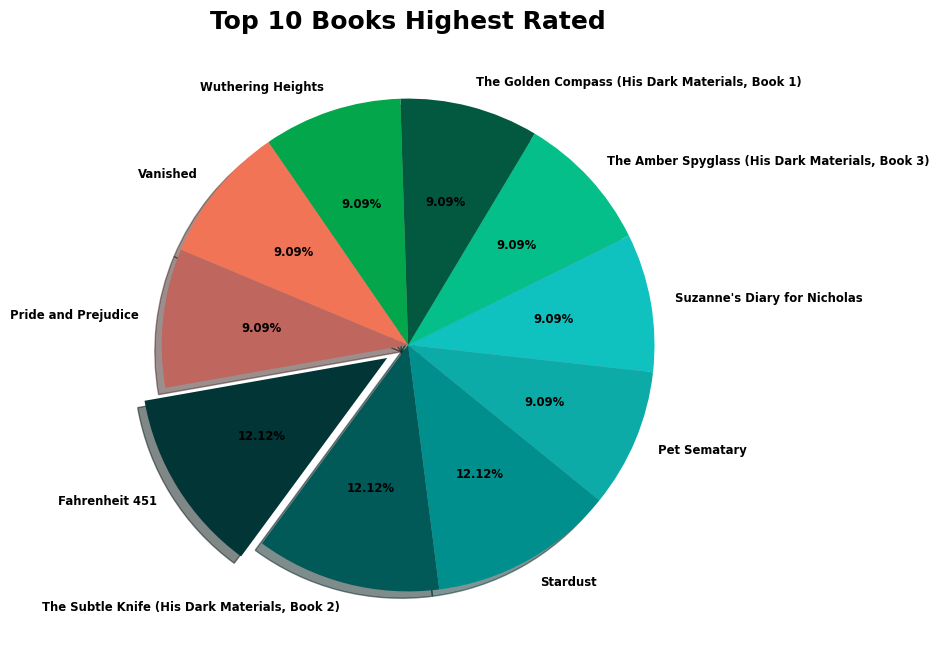

In [21]:
#plotting for top 10 books with highest rating
plt.figure(figsize=(10,8))
plt.pie(top_10_books,
       labels = top_10_books.index,
       explode = [0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
       autopct='%.2f%%',
       shadow=True,
       colors = mycolors,
       startangle=190,
       textprops={'size':'small',
                 'fontweight':'bold',

                 'color':'black'})
plt.title("Top 10 Books Highest Rated",fontsize = 18,fontweight = 'bold')
plt.show()

In [22]:
#checking with top 10 lowest rated books
top_10_low_books = low_ratings.Book_title.value_counts().tail(10)
top_10_low_books

Four To Score (A Stephanie Plum Novel)                    1
Shadowrun: Nosferatu (Shadowrun (Roc))                    1
To the Nines: A Stephanie Plum Novel                      1
Woman, Thou Art Loosed: Healing the Wounds of the Past    1
All I Asking for Is My Body (Kolowalu Book)               1
Tar Baby                                                  1
ANGELA'S ASHES                                            1
Lame (Collection Sextant)                                 1
Sons from Afar                                            1
The Millstone                                             1
Name: Book_title, dtype: int64

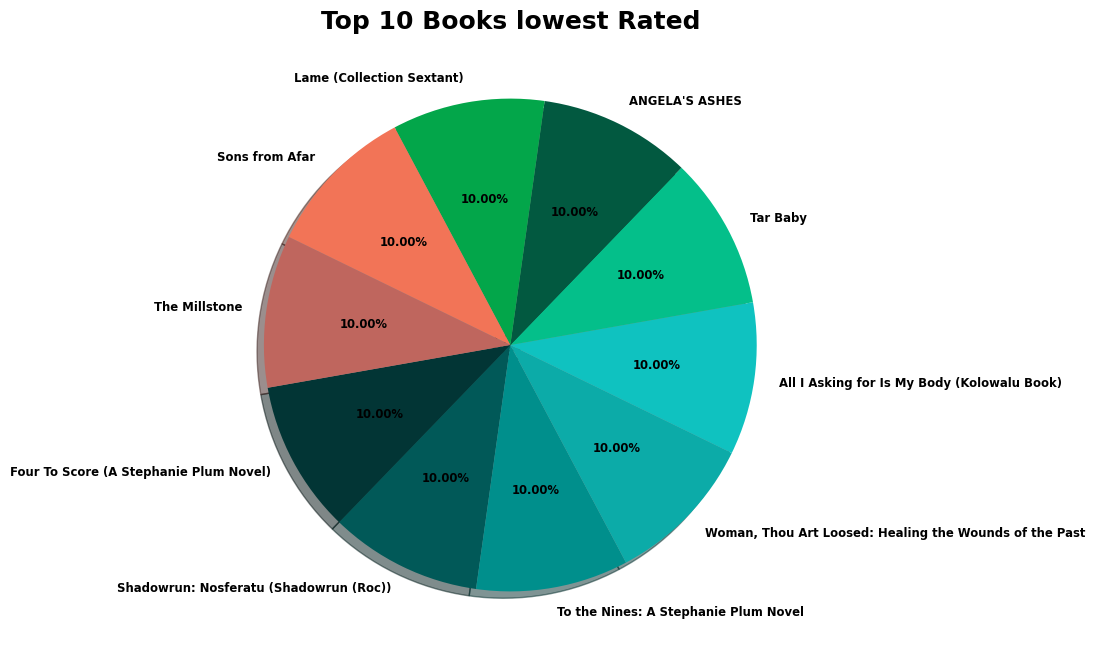

In [23]:
#plotting for top 10 books with lowest rating
plt.figure(figsize=(12,8))
plt.pie(top_10_low_books,
       labels = top_10_low_books.index,
       explode = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
       autopct='%.2f%%',
       shadow=True,
       colors = mycolors,
       startangle=190,
       textprops={'size':'small',
                 'fontweight':'bold',

                 'color':'black'})
plt.title("Top 10 Books lowest Rated",fontsize = 18,fontweight = 'bold')
plt.show()


Text(0.5, 1.0, 'Recurrence of Ratings')

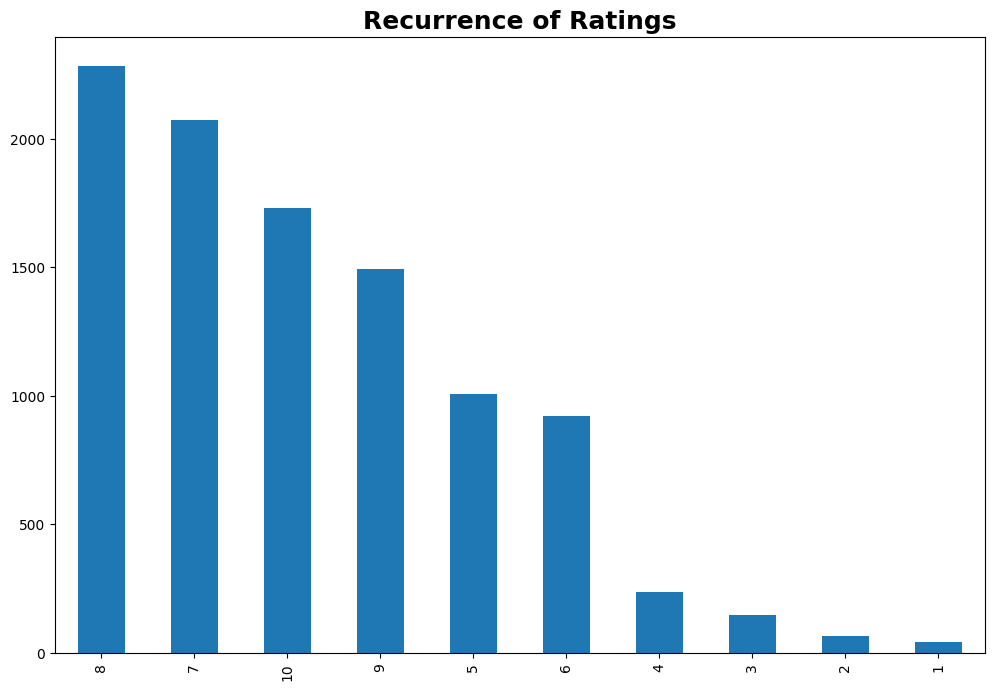

In [24]:
#plotting to check frequency of ratngs
plt.figure(figsize=(12,8))
df['Ratings'].value_counts().plot(kind='bar')
plt.title('Recurrence of Ratings',fontsize = 18,fontweight = 'bold')

In [25]:
#grouping to compute the count of total ratings
df.groupby('Book_title')['Ratings'].count().sort_values(ascending = False).head(10)

Book_title
Fahrenheit 451                                     5
Vanished                                           4
Stardust                                           4
Ender's Game (Ender Wiggins Saga (Paperback))      4
The Subtle Knife (His Dark Materials, Book 2)      4
The Amber Spyglass (His Dark Materials, Book 3)    4
Charlie and the Chocolate Factory                  4
The Hitchhiker's Guide to the Galaxy               3
The Golden Compass (His Dark Materials, Book 1)    3
My Side of the Mountain                            3
Name: Ratings, dtype: int64

In [26]:
#creating a dataframe for average rating for titles
ratings = pd.DataFrame(df.groupby('Book_title')['Ratings'].mean())
ratings.head()

,Ratings
Book_title,
"Jason, Madison &amp",8.0
Other Stories;Merril;1985;McClelland &amp,6.0
Repairing PC Drives &amp,4.0
'48,7.0
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,8.0


In [27]:
#groupiing and calculating numbe rof ratings for each book
ratings['num of ratings'] = pd.DataFrame(df.groupby('Book_title')['Ratings'].count())
ratings.head()

,Ratings,num of ratings
Book_title,,
"Jason, Madison &amp",8.0,1
Other Stories;Merril;1985;McClelland &amp,6.0,1
Repairing PC Drives &amp,4.0,1
'48,7.0,1
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,8.0,1


In [28]:
#creating our pivot table
user_books_df = df.pivot_table(index='User_Id',columns='Book_title',values = 'Ratings',fill_value=0)

In [29]:
user_books_df

Book_title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
User_Id,,,,,,,,,,,,,,,,,,,,,
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278846,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,0,0


In [30]:
#sorting ratings descending order
ratings.sort_values('num of ratings',ascending=False).head(10)

,Ratings,num of ratings
Book_title,,
Fahrenheit 451,7.000000,5
Vanished,6.500000,4
Stardust,8.500000,4
Ender's Game (Ender Wiggins Saga (Paperback)),6.250000,4
"The Subtle Knife (His Dark Materials, Book 2)",8.750000,4
"The Amber Spyglass (His Dark Materials, Book 3)",8.250000,4
Charlie and the Chocolate Factory,6.500000,4
The Hitchhiker's Guide to the Galaxy,8.333333,3
"The Golden Compass (His Dark Materials, Book 1)",8.333333,3


In [31]:
#taking any two books with higher ratings
Fahrenheit_user_ratings = user_books_df['Fahrenheit 451']
Vanished_user_ratings = user_books_df['Vanished']
Vanished_user_ratings.head()

User_Id
8     0
9     0
10    0
12    0
14    0
Name: Vanished, dtype: int64

In [32]:
#using the correlation method
sim_fahrenheit = user_books_df.corrwith(Fahrenheit_user_ratings)
sim_vanished = user_books_df.corrwith(Vanished_user_ratings)

In [33]:
corr_vanished = pd.DataFrame(sim_vanished,columns=['correlation'])
corr_vanished.dropna(inplace=True)
corr_vanished.head()

,correlation
Book_title,
"Jason, Madison &amp",-0.000904
Other Stories;Merril;1985;McClelland &amp,-0.000904
Repairing PC Drives &amp,-0.000904
'48,-0.000904
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,-0.000904


In [34]:
#sorting values of correlation
corr = corr_vanished.sort_values('correlation',ascending=False).head(10)
corr

,correlation
Book_title,
Vanished,1.000000
The Northern Lights,0.454464
Kits Law,0.454464
Chasing Cezanne,0.454464
Notes from the Hyena's Belly: Memories of My Ethiopian Boyhood,0.454464
Last Summer at Barebones,0.454464
Home From the Vinyl Cafe,0.454464
Oxygen,0.454464
Canoe Lake,0.454464


In [35]:
#joining our ratings
corr_vanished = corr_vanished.join(ratings['Ratings'])
corr_vanished.head()

,correlation,Ratings
Book_title,,
"Jason, Madison &amp",-0.000904,8.0
Other Stories;Merril;1985;McClelland &amp,-0.000904,6.0
Repairing PC Drives &amp,-0.000904,4.0
'48,-0.000904,7.0
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,-0.000904,8.0


In [36]:
#joining our  num of ratings
corr_vanished = corr_vanished.join(ratings['num of ratings'])
corr_vanished.head()

,correlation,Ratings,num of ratings
Book_title,,,
"Jason, Madison &amp",-0.000904,8.0,1
Other Stories;Merril;1985;McClelland &amp,-0.000904,6.0,1
Repairing PC Drives &amp,-0.000904,4.0,1
'48,-0.000904,7.0,1
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,-0.000904,8.0,1


In [37]:
#building a matrix user ids on one axis
corr_vanished[corr_vanished['Ratings']>5].sort_values('correlation',ascending=False).head()

,correlation,Ratings,num of ratings
Book_title,,,
Vanished,1.000000,6.5,4
The Northern Lights,0.454464,8.0,1
Amistad,0.454464,6.0,1
Tender at the Bone: Growing Up at the Table,0.454464,7.0,1
Contract: Paternity (Delta Justice) (Harlequin Delta Justice),0.378570,8.0,1


In [38]:
#checking with reccomendation system for Fahrenheit 451
corr_fahrenheit = pd.DataFrame(sim_fahrenheit,columns=['correlation'])
corr_fahrenheit.dropna(inplace=True)
corr_fahrenheit= corr_fahrenheit.join(ratings['num of ratings'])
corr_fahrenheit[corr_fahrenheit['num of ratings']>2].sort_values('correlation',ascending=False).head()

,correlation,num of ratings
Book_title,,
Fahrenheit 451,1.000000,5
The Neverending Story,0.284962,3
The Hero and the Crown,0.238223,3
Vanished,0.224660,4
Ender's Game (Ender Wiggins Saga (Paperback)),0.161969,4


In [39]:
user_books_df

Book_title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
User_Id,,,,,,,,,,,,,,,,,,,,,
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278846,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,0,0


In [40]:
#selecting matrix upon our requirement
df.iloc[:5,:5]

,User_Id,Book_title,Ratings
0,276726,Classical Mythology,5
1,276729,Clara Callan,3
2,276729,Decision in Normandy,6
3,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,276737,The Mummies of Urumchi,6


In [41]:
#function to define reccomendation and give us back reccommendations
def give_reco(customer_id):
    item = list(user_sim_data.sort_values([customer_id],ascending=False).head(100).index)
    books_list = []
    for i in item:
        books_list=books_list+list(df[df['User_Id']==i]['Book_title'])
    return set(books_list)-set(df[df['User_Id']==customer_id]['Book_title'])

In [42]:
# Calculating Cosine Similarity between Users
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation, jaccard

In [43]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,Ratings,num of ratings
Book_title,,
Fahrenheit 451,7.000000,5
Vanished,6.500000,4
Stardust,8.500000,4
Ender's Game (Ender Wiggins Saga (Paperback)),6.250000,4
"The Subtle Knife (His Dark Materials, Book 2)",8.750000,4
"The Amber Spyglass (His Dark Materials, Book 3)",8.250000,4
Charlie and the Chocolate Factory,6.500000,4
The Hitchhiker's Guide to the Galaxy,8.333333,3
"The Golden Compass (His Dark Materials, Book 1)",8.333333,3


In [44]:
stardust_user_ratings = user_books_df['Stardust']
fahrenheit_user_rating = user_books_df['Fahrenheit 451']
fahrenheit_user_rating.head()

User_Id
8     0
9     0
10    0
12    0
14    0
Name: Fahrenheit 451, dtype: int64

In [45]:
similar_to_fahrenheit = user_books_df.corrwith(fahrenheit_user_rating)
similar_to_stardust = user_books_df.corrwith(stardust_user_ratings)

In [46]:
corr_fahrenheit = pd.DataFrame(similar_to_fahrenheit,columns=['Correlation'])
corr_fahrenheit.dropna(inplace=True)
corr_fahrenheit.head()

,Correlation
Book_title,
"Jason, Madison &amp",-0.000958
Other Stories;Merril;1985;McClelland &amp,-0.000958
Repairing PC Drives &amp,-0.000958
'48,-0.000958
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,-0.000958


In [47]:
corr_fahrenheit.sort_values('Correlation',ascending=False).head(10)

,Correlation
Book_title,
Fahrenheit 451,1.000000
The Day I Swapped My Dad for 2 Goldfish,0.596326
A la vora del pou (El BalancÃ­),0.596326
"Father Of Two (The Daddy School) (Harlequin Superromance, No 771)",0.596326
Contes de fÃ?Â©es Ã?Â l'usage des moyennes personnes,0.596326
Silent Witness,0.596326
The Ambassador's Women,0.596326
Bloodcurdling Tales of Horror,0.596326
"Julia (Circle Of Friends) (Harlequin Superromance, 813)",0.596326


In [48]:
corr_stardust = pd.DataFrame(similar_to_stardust,columns=['Correlation'])
corr_stardust.dropna(inplace=True)
corr_stardust = corr_stardust.join(ratings['num of ratings'])
corr_stardust[corr_stardust['num of ratings']>4].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
Book_title,,
Fahrenheit 451,-0.001908,5


In [49]:
user_books_df.head()

Book_title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
User_Id,,,,,,,,,,,,,,,,,,,,,
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# Calculating Cosine Similarity between Users
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation, jaccard

In [51]:
user_sim = 1 - pairwise_distances(user_books_df.values, metric = 'cosine')
user_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [52]:
# Store the results in a dataframe
user_sim_df = pd.DataFrame(user_sim)
user_sim_df

,0,1,2,3,4,5,6,7,8,9,...,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [53]:
user_sim_df.iloc[:5,:5]

,0,1,2,3,4
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0


In [54]:
np.fill_diagonal(user_sim, 0)
user_sim_df.iloc[0:5,0:5]

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [55]:
# Set the index and column name to user Ids
user_sim_df.index = list(user_books_df.index)
user_sim_df.columns = list(user_books_df.index)
user_sim_df

,8,9,10,12,14,16,17,19,22,26,...,278831,278832,278836,278843,278844,278846,278849,278851,278852,278854
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
user_id_eight = user_sim_df.sort_values([9], ascending=False).head(100)
user_id_eight[9]

8         0.0
161755    0.0
161744    0.0
161749    0.0
161750    0.0
         ... 
161441    0.0
161436    0.0
161434    0.0
161431    0.0
161423    0.0
Name: 9, Length: 100, dtype: float64

In [57]:
# Most Similar Users
user_sim_df.idxmax(axis=1)

8              8
9              8
10             8
12             8
14             8
           ...  
278846         8
278849         8
278851    278202
278852         8
278854         8
Length: 2182, dtype: int64

Recommnedation Based on Cosine Similarity



In [58]:
def give_reco(customer_id):
    tem = list(user_sim_df.sort_values([customer_id],ascending=False).head(100).index)
    #print('similar customer ids:',tem)
    movie_list=[]
    for i in tem:
        movie_list=movie_list+list(books[books['user_id']==i]['title'])
    #print('Common movies within customer',movie_list)
    return set(movie_list)-set(books[books['user_id']==customer_id]['title'])

Conclusions

1)Recommendation systems are divided into two types correlation and cosine based, under that we have item based filtering and user based filtering

2)In this we went with correlation item based filtering for all the books and selecting two highest rated books we compared and filtered with similiarity to other books and found out how well we can reccomend

3)In the second method we went with cosine based method with user based filtering we created a matrix and with randomly selecting two users we found the similiarities and found the books they would like and we can reccomend them in future

4)Recommendation systems are lazy learning,when we have large datasets we have to go with dimension reduction by random sampling,PCA,discard the most popular items or clustering